In [1]:
from matplotlib import pyplot as plt
import random
from copy import deepcopy
import networkx as nx
import callable
import time
import os

In [2]:
def maxNumOfColours(graph):
    maxDegree = 0
    for i in graph:
        degree = len(list(graph.neighbors(i)))
        # print(i,degree)
        if degree > maxDegree:
            maxDegree = degree
            
    return maxDegree + 1

In [3]:
def normEdge(u, v):
    return (u, v) if u < v else (v, u)

In [4]:
def calcConflicts(edges, edgesIndex, solution, neighbourhood):
    num  = 0
    
    for i in range(len(edges)):
        edge = edges[i]
        myNeighbours = neighbourhood[edge]

        for nei in myNeighbours:
            idx = edgesIndex[nei]
            if solution[idx] == solution[i]:
                num += 1
        
    return (num // 2)


In [5]:
def recalcConflicts(edges, edgesIndex, oldConf, solution, neighbourhood, oldColour, newColour, i):
    num = 0

    edge = edges[i]
    myNeighbours = neighbourhood[edge]

    for nei in myNeighbours:
        idx = edgesIndex[nei]
        if solution[idx] == oldColour:
            num -= 1
        if solution[idx] == newColour:
            num += 1
    
    return oldConf + num


In [6]:
def getNeighbours(graph):
    neighbourhood = {normEdge(u, v): [] for _, (u, v) in enumerate(graph.edges())} 


    for edge in graph.edges():
        u, v = edge
        uNei = list(graph.neighbors(u))
        vNei = list(graph.neighbors(v))
        uNei.remove(v)
        vNei.remove(u)
        mapa = {}

        for i in    uNei:
            nei = normEdge(u, i)
            neighbourhood[edge].append(nei)
            mapa[nei] = True

        for i in vNei:
            nei = normEdge(v, i)
            if nei not in mapa:
              neighbourhood[edge].append(nei)
    # print(neighbourhood)

    return neighbourhood

In [7]:
def shaking(solution, k, maxDegree):
    newSolution = deepcopy(solution)
    chosen = random.sample(range(len(solution)),k)
    
    for i in chosen:
        newSolution[i] = random.randrange(1, maxDegree+1)
    return newSolution

In [8]:
def lsFirst(edges, edgesIndex, solution, fitness, maxDegree, neighbourhood):
    newSolution = deepcopy(solution)
    improved = True

    while improved:
        improved = False
        indices = list(range(len(solution)))
        random.shuffle(indices)

        for i in indices:
            oldColour = newSolution[i]
            for colour in range(1,maxDegree+1):
                if colour == oldColour:
                    continue
                newSolution[i] = colour
                # newSolution[i] = random.randrange(1, maxDegree+1)
                # newFitness = calcConflicts(graph, newSolution, neighbourhood)
                newFitness = recalcConflicts(edges, edgesIndex, fitness, newSolution, neighbourhood, oldColour, colour, i)
                if newFitness < fitness:
                    fitness = newFitness
                    improved = True
                    break
                else:
                    newSolution[i] = oldColour
    return newSolution, fitness


In [9]:
def lsBest(edges, edgesIndex, solution, fitness, maxDegree, neighbourhood):
    newSolution = deepcopy(solution)
    improved = True

    while improved:
        improved = False
        bestFitness = fitness
        bestIdx = -1
        bestColour = -1

        for i in range(len(solution)):
            oldColour = newSolution[i]
            for colour in range(1,maxDegree+1):
                if colour == oldColour:
                    continue
                newSolution[i] = colour
                # newFitness = calcConflicts(graph, newSolution, neighbourhood)
                newFitness = recalcConflicts(edges, edgesIndex, fitness, newSolution, neighbourhood, oldColour, colour, i)
                if newFitness < bestFitness:
                    bestFitness = newFitness
                    bestIdx = i
                    bestColour = colour
                newSolution[i] = oldColour
        
        if bestIdx != -1:
            newSolution[bestIdx] = bestColour
            fitness = bestFitness
            improved = True

    return newSolution, fitness


In [10]:
def initialize(graph, max_degree):
    return [random.randrange(1,max_degree + 1) for _ in range(len(graph.edges))]

In [11]:
def vns(graph, maxDegree, maxIters, neighRange, probVal, localSearch: callable):
    solution = initialize(graph,maxDegree)
    neighbourhood = getNeighbours(graph)
    edges = list(graph.edges())
    edgesIndex = {normEdge(u, v) : i for i, (u, v) in enumerate(edges)}

    fitness = calcConflicts(edges, edgesIndex, solution, neighbourhood)
    k = 1

    for it in range(maxIters):
        # for k in range(1,neighRange+1):
        while k <= neighRange:
            
            newSolution = shaking(solution, k, maxDegree)
            newFitness = calcConflicts(edges, edgesIndex, newSolution, neighbourhood)
            newSolution, newFitness = localSearch(edges, edgesIndex, newSolution, newFitness, maxDegree, neighbourhood)

            if newFitness < fitness or (newFitness == fitness and random.random() < probVal):
                fitness = newFitness
                solution = deepcopy(newSolution)
                k = 1
            else: 
                # k = (k % neighRange) + 1
                k += 1
    return solution, fitness



In [12]:
def draw(graph, colouring):
    nx.draw(graph, edge_color=colouring,with_labels=True)
    plt.show()

In [13]:
def solve(graph, iters, neighRange, prob, minus, localSearch:callable):
    maxDegree = maxNumOfColours(graph) - minus
    startTime = time.time()
    solution, fitness = vns(graph, maxDegree, iters, neighRange, prob, localSearch)
    endTime = time.time()
    tim = endTime - startTime
    numColours = list(set(solution))
    # print(solution," ",fitness," ", tim,"num of col: ",len(numColours))
    print(fitness," ", tim,"num of col: ",len(numColours))
    draw(graph, solution)
    return tim


In [14]:
def readGraph(filepath):

    graph = nx.Graph()
    numNodes: int
    edges = []

    with open(filepath) as f:
        lines = f.readlines()
        numNodes = int(lines[0].split()[2])
        edges = [tuple(map(int,line.split()[1:])) for line in lines[1:]]

    graph.add_nodes_from(range(1, numNodes + 1))
    graph.add_edges_from(edges)
    return graph


In [15]:
def testGraphs(dir): #params
    files = os.listdir(dir)

    for file in files:
        filepath = os.path.join(dir,file)
        print(f"{file} testing...")

        graph = readGraph(filepath)
        solve(graph, 100, 4, 0.5, 1, lsBest)

In [16]:
def testOneGraph(filepath):
    graph = readGraph(filepath)
    solve(graph, 10, 5, 0.5,0,lsFirst)

0   0.9497172832489014 num of col:  18


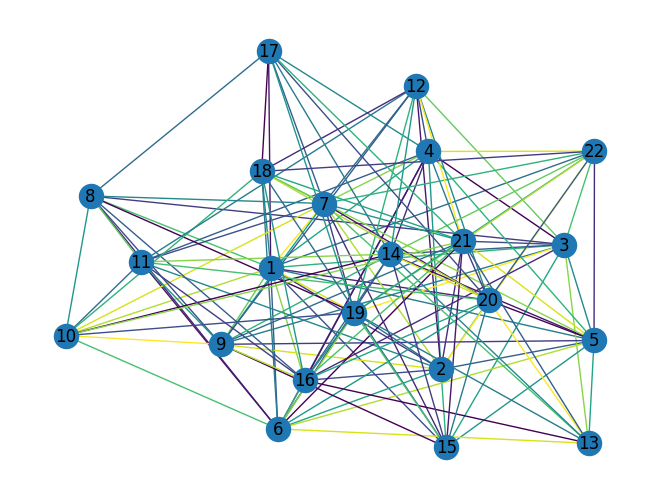

In [18]:
testOneGraph("/home/ivana/minimumEdgeColoring/big/big22.txt")

0   0.33710145950317383 num of col:  24


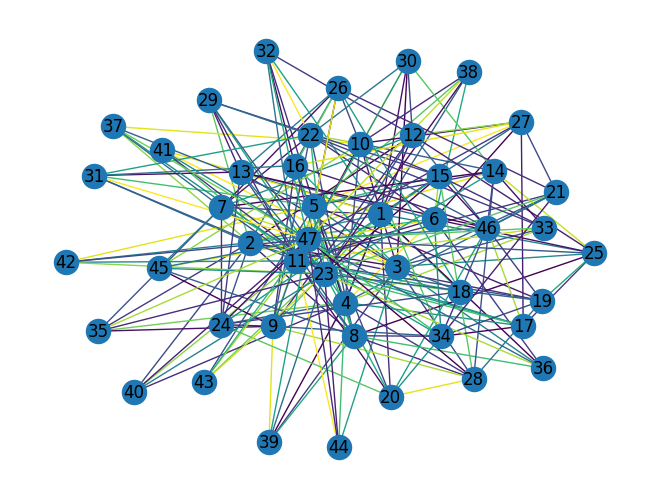

In [19]:
testOneGraph("/home/ivana/minimumEdgeColoring/big/big47.6.txt")

0   4.005790710449219 num of col:  50


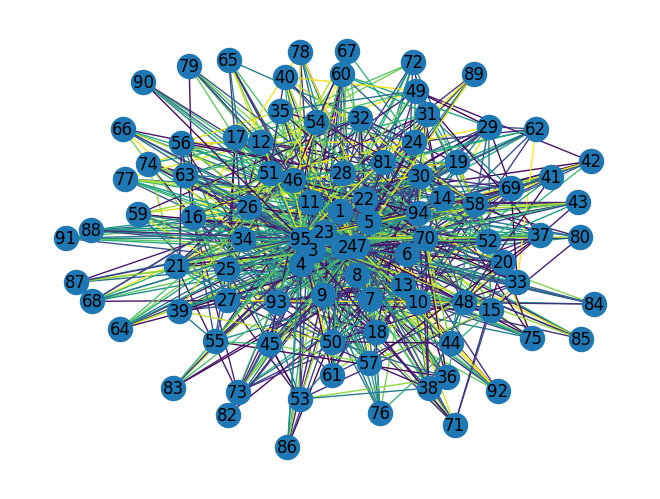

In [21]:
testOneGraph("big/big75.txt")

graph5.txt testing...
0   0.0006098747253417969 num of col:  3


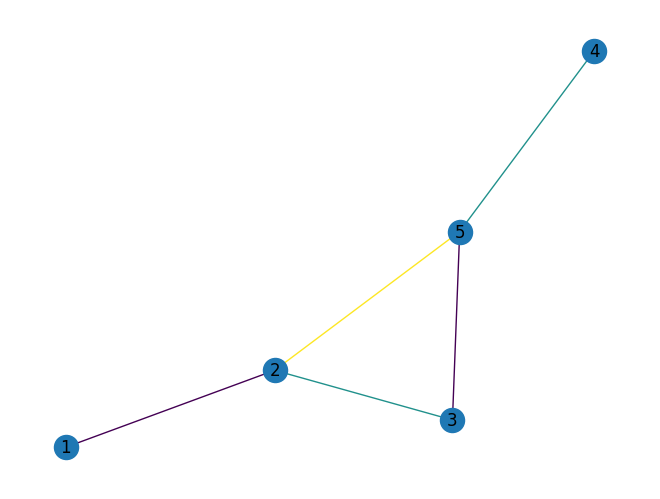

graph6e.txt testing...
0   0.0007994174957275391 num of col:  3


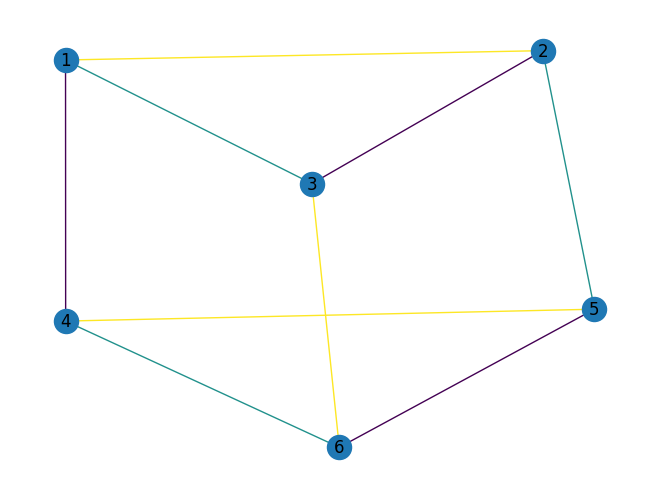

graph10.txt testing...
1   0.0015106201171875 num of col:  3


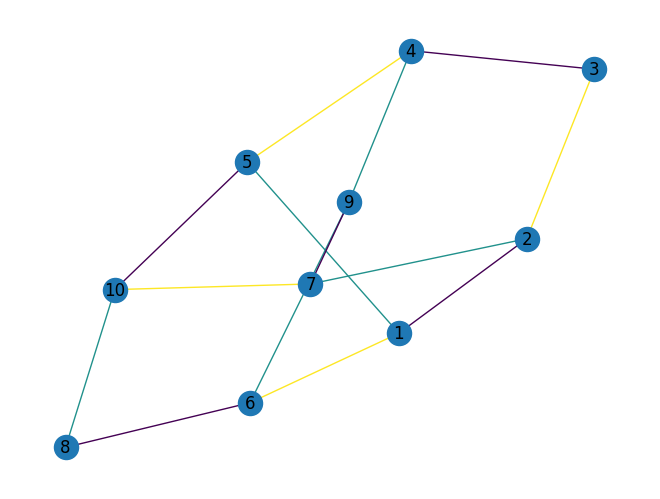

In [22]:
testGraphs("/home/ivana/minimumEdgeColoring/tests")